In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Define positions
user_position = (100, 100)
base_station_position = (0, 0)
uav_position = (50, 50)  # Example UAV-RIS position

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1

# Define channel gain and Rayleigh fading parameters
path_loss_exponent = 2.0
noise_power = 0.01

# Maximum number of RIS elements
max_ris_elements = 300

# SNR with UAV-RIS (Unoptimized)
snr_uav_unoptimized = 0

In [40]:
snrs_uav_unoptimized = []
snrs_uav_optimized = []

In [41]:
for num_elements in range(50, max_ris_elements + 1, 1):

    def calculate_distance(point1, point2):
        return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    user_bs_distance = calculate_distance(user_position, base_station_position)
    user_uav_distance = calculate_distance(user_position, uav_position)
    bs_uav_distance = calculate_distance(base_station_position, uav_position)

    # Generate channel coefficients and fading
    channel_coefficients = np.random.rand(num_elements)
    fading = np.random.rand(num_elements)
    # rayleigh_fading = np.random.rayleigh(scale=1, size=num_elements)

    def calculate_elements(channel_coefficients, fading):
        snr_values = (
            channel_coefficients
            * fading
            / (channel_coefficients * (1 - fading) + noise_power)
        )
        power_values = channel_coefficients * fading + channel_coefficients * (
            1 - fading
        )
        return np.column_stack((snr_values, power_values))

    elements = calculate_elements(channel_coefficients, fading)

    def calculate_snr_power(channel_coefficients, fading):
        signal_power = np.sum(channel_coefficients * fading)
        energy_power = np.sum(channel_coefficients * (1 - fading))

        # Generate AWGN noise based on noise power
        noise_samples = np.random.normal(scale=np.sqrt(noise_power))

        # Add noise to the received signal
        signal_with_noise = signal_power + noise_samples

        # Compute the SNR considering noise
        snr = signal_with_noise / (energy_power + noise_power)
        power = energy_power + signal_with_noise
        return snr, power

    def generate_initial_indices(channel_coefficients, fading):
        sorted_indices = np.argsort(channel_coefficients * fading)
        energy_indices = sorted_indices[: num_elements // 2]
        signal_indices = sorted_indices[num_elements // 2 :]
        return energy_indices, signal_indices

    def evaluate_fitness(energy_indices, signal_indices):
        snr, power = calculate_snr_power(
            channel_coefficients[energy_indices], fading[energy_indices]
        )
        return 1 / (snr * power)

    def genetic_algorithm():
        # Generate initial values for energy_indices and signal_indices
        energy_indices, signal_indices = generate_initial_indices(
            channel_coefficients, fading
        )

        # Initialize population
        population = [energy_indices] * population_size

        for i in range(num_generations):
            new_population = []
            for parent1, parent2 in zip(population[::2], population[1::2]):
                if np.random.rand() < crossover_rate:
                    crossover_point = np.random.randint(1, num_elements // 2)
                    child1 = np.concatenate(
                        (parent1[:crossover_point], parent2[crossover_point:])
                    )
                    child2 = np.concatenate(
                        (parent2[:crossover_point], parent1[crossover_point:])
                    )
                else:
                    child1 = parent1
                    child2 = parent2

                for child in [child1, child2]:
                    if np.random.rand() < mutation_rate:
                        mutation_index = np.random.randint(num_elements // 2)
                        child[mutation_index] = np.random.randint(num_elements)
                new_population.extend([child1, child2])

            population = new_population

            best_individual = min(
                population,
                key=lambda ind: evaluate_fitness(
                    ind, list(set(range(num_elements)) - set(ind))
                ),
            )

            best_energy_indices = best_individual
            best_signal_indices = list(set(range(num_elements)) - set(best_individual))
            best_snr, best_power = calculate_snr_power(
                channel_coefficients[best_energy_indices], fading[best_energy_indices]
            )

            if i == 0:
                global snr_uav_unoptimized
                snr_uav_unoptimized = best_snr

        return best_energy_indices, best_signal_indices, best_snr, best_power

    # Run the Genetic Algorithm
    best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

    # Desired initial SNR without UAV-RIS in dB
    desired_initial_snr_dB = 0.2

    # Convert desired initial SNR from dB to linear scale
    desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

    # Calculate the required base station power to achieve the desired initial SNR
    P_bs = (user_bs_distance**path_loss_exponent + noise_power) * desired_initial_snr

    # SNR directly from the base station (Without UAV-RIS)
    snr_without_ris = P_bs / (user_bs_distance**path_loss_exponent + noise_power)

    # Calculate the improvement percentage
    improvement_percentage = (
        (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100
    )

    print(
        "Number of elements: {}, Improvement percentage: {:.2f}%".format(
            num_elements, improvement_percentage
        )
    )

    snrs_uav_unoptimized.append(snr_uav_unoptimized)
    snrs_uav_optimized.append(best_snr)

Number of elements: 50, Improvement percentage: 98.19%
Number of elements: 51, Improvement percentage: 56.69%
Number of elements: 52, Improvement percentage: 102.79%
Number of elements: 53, Improvement percentage: 106.47%
Number of elements: 54, Improvement percentage: 68.86%
Number of elements: 55, Improvement percentage: 68.85%
Number of elements: 56, Improvement percentage: 96.27%
Number of elements: 57, Improvement percentage: 44.08%
Number of elements: 58, Improvement percentage: 65.36%
Number of elements: 59, Improvement percentage: 82.89%
Number of elements: 60, Improvement percentage: 63.73%
Number of elements: 61, Improvement percentage: 53.97%
Number of elements: 62, Improvement percentage: 63.51%
Number of elements: 63, Improvement percentage: 81.19%
Number of elements: 64, Improvement percentage: 57.38%
Number of elements: 65, Improvement percentage: 49.70%
Number of elements: 66, Improvement percentage: 67.02%
Number of elements: 67, Improvement percentage: 51.09%
Number o

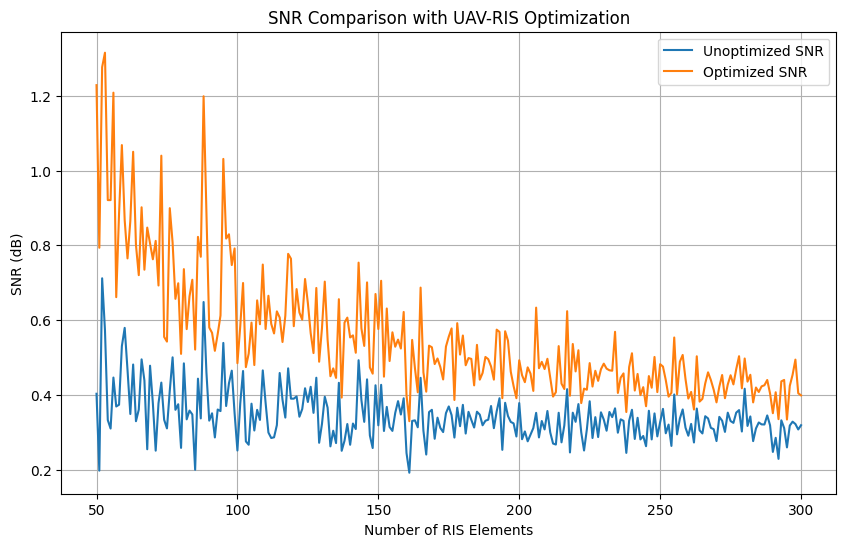

In [42]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(50, max_ris_elements + 1, 1), snrs_uav_unoptimized, label="Unoptimized SNR")
plt.plot(range(50, max_ris_elements + 1, 1), snrs_uav_optimized, label="Optimized SNR")
plt.xlabel("Number of RIS Elements")
plt.ylabel("SNR (dB)")
plt.title("SNR Comparison with UAV-RIS Optimization")
plt.legend()
plt.grid(True)
plt.show()